# Benchmarking TSP on different solvers

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("benchmark.csv")
df = df.dropna(subset=['solve_cost'])
# df.fillna({"solve_cost": 0}, inplace=True)



df['execution_time'] = pd.to_timedelta(df['execution_time']).dt.total_seconds()
df

,number_of_cities,solve_cost,execution_time,tour,solver
0,4,13.0,0.000000,"(0, 1, 3, 2)",brute_force
1,4,13.0,0.947313,"(1, 3, 2, 0)",Fixstar
2,4,13.0,0.009999,"(1, 3, 2, 0)",Gurobi
3,4,13.0,0.190523,"(2, 0, 1, 3)",D-Wave
4,5,13.0,0.000000,"(0, 1, 4, 2, 3)",brute_force
5,5,13.0,1.006378,"(1, 2, 3, 0, 4)",Fixstar
6,5,13.0,0.019999,"(4, 1, 0, 2, 3)",Gurobi
7,5,13.0,0.220102,"(4, 3, 2, 0, 1)",D-Wave
8,6,17.0,0.001000,"(0, 3, 1, 2, 5, 4)",brute_force
9,6,17.0,0.976863,"(4, 5, 2, 1, 3, 0)",Fixstar


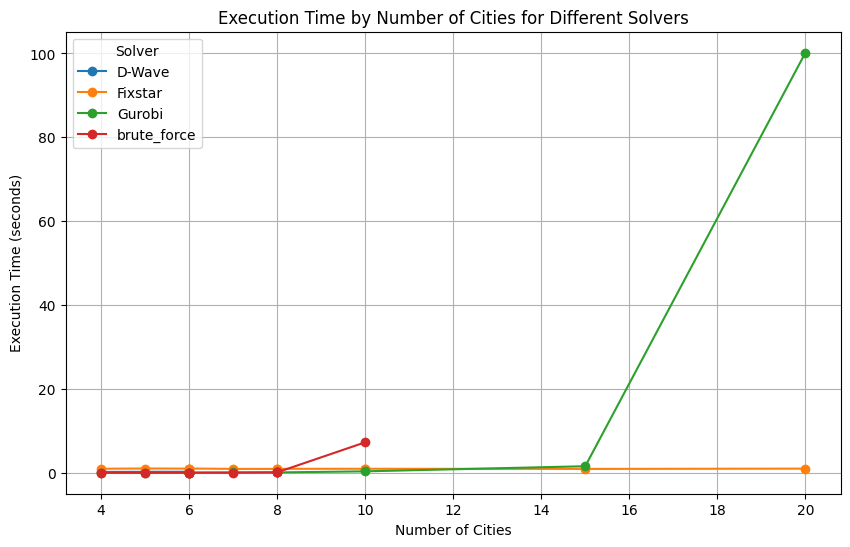

In [ ]:


#Create the plot
plt.figure(figsize=(10, 6))
# Group data by solver and plot each as a separate line
for solver, group_data in df.groupby('solver', as_index=False):
    plt.plot(group_data['number_of_cities'], group_data['execution_time'], marker='o', label=solver)
        

# Set labels and title
plt.ylim(0, 5)  # Limit y-axis to a maximum of 5 seconds
plt.xlabel("Number of Cities")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time by Number of Cities for Different Solvers")
plt.legend(title="Solver")
plt.grid(True)
plt.show()